# Live Overhead Press Checker using Frame Analysis

Live realtime analysis using frame analysis technique.

Overhead press instructions: Stand side on with right-side facing towards the camera. Start with hands on the barbell slightly wider than shoulder width apart. Push the bar directly up, moving chin back.

Avoid:
- Bending knees for momentum
- Bending/arching back
- Pushing the bar forwards when pushing up, bar should go directly up

<div>
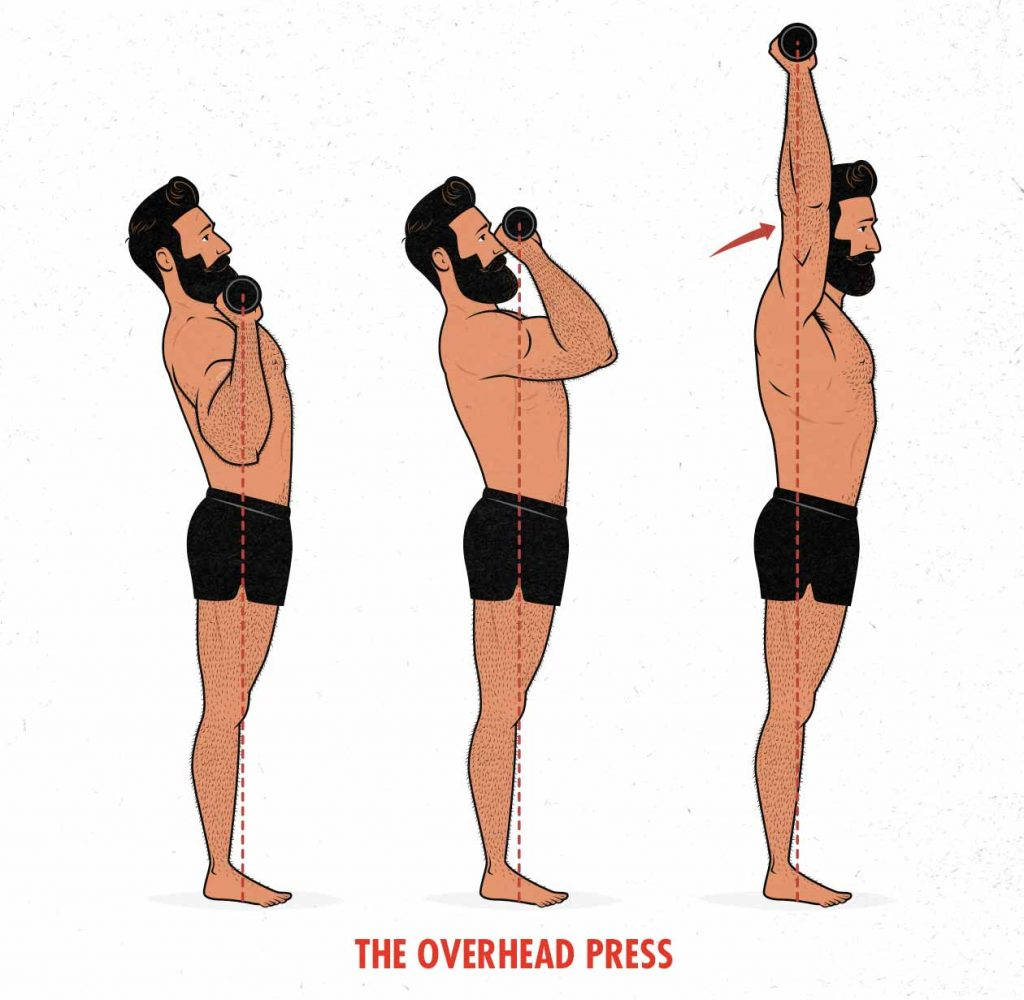
</div>
https://outlift.com/overhead-press-for-size/

## TOC:
0. [Setup](#0.-Import-Libraries-&-Setup)
1. [Display](#1.-Display)

# 0. Import Libraries & Setup

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import math

# ML libraries
import sklearn
from sklearn.svm import LinearSVC
from joblib import dump, load

In [2]:
def get_landmark(landmarks):
    unboxed_landmark = {}
    
    for i in range(33):
        unboxed_landmark['x' + str(i)] = landmarks.landmark[i].x
        unboxed_landmark['y' + str(i)] = landmarks.landmark[i].y
        unboxed_landmark['z' + str(i)] = landmarks.landmark[i].z
    
    df = pd.DataFrame([unboxed_landmark])    
    
    return df

In [3]:
# Load model and choose model to use
svc_model = load('svc-overhead-press-mistakes.joblib') # Best performing model
model = svc_model

# 1. Display

In [4]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    ba = [j for i in ba for j in i]
    bc = [j for i in bc for j in i]
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [5]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture(0)
with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:

    while cap.isOpened():
        ret, image = cap.read()
        
        height, width, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
 
        display_msg = 'Cannot detect skeleton in frame'

        if results.pose_landmarks != None:
            # Setup heuristic values for input into model
            heuristics = {}

            heuristics['hip_angle'] = get_angle(get_landmark(results.pose_landmarks), 11, 23, 25)
            heuristics['bicep_angle'] = get_angle(get_landmark(results.pose_landmarks), 11, 13, 15)
            heuristics['knee_angle'] = get_angle(get_landmark(results.pose_landmarks), 23, 25, 27)
            heuristics['foot_angle'] = get_angle(get_landmark(results.pose_landmarks), 25, 27, 31)
            heuristics['elbow_hip_angle'] = get_angle(get_landmark(results.pose_landmarks), 13, 11, 23)
            
            # Get the ML model's prediction
            prediction = (model.predict(pd.DataFrame([heuristics]))[0])[:10]
            
            # Set the display message
            if prediction == 'back':
                display_msg = 'Keep your back straight'
            elif prediction == 'knees':
                display_msg = 'Keep your knees straight'
            elif prediction == 'good':
                display_msg = 'Good so far, keep it up'
            elif prediction == 'forward':
                display_msg = 'Stop pushing the bar forwards'
        
        # Show the display message on the UI
        cv2.rectangle(image, (0, 0), (900, 60), (0, 0, 0), -1)
        cv2.putText(image, display_msg, (0,40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
        cv2.namedWindow('output', cv2.WINDOW_NORMAL) # Allows you to manually change the size of the window
        cv2.imshow('output', image)

        k = cv2.waitKey(1)
        
        # Press ESC to quit
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()